# Introduction to ARIMA Models
We'll investigate a variety of different forecasting models in upcoming sections, but they all stem from ARIMA.

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

# AR(p)
# Autoregressive Model

In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coeffients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>
Specifically, for an <strong>AR(1)</strong> model: $-1 \lt \phi_1 \lt 1$<br>
and for an <strong>AR(2)</strong> model: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Models <strong>AR(3)</strong> and higher become mathematically very complex. Fortunately statsmodels does all the heavy lifting for us.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html'>ar_model.AR</a></strong><font color=black>(endog[, dates, freq, missing])</font>&nbsp;&nbsp;Autoregressive AR(p) model<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.ARResults.html'>ar_model.ARResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class to hold results from fitting an AR model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://otexts.com/fpp2/AR.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive models</font><br>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive model</font></div>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.ar_model import AutoReg as AR
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# DICKEY FULLER TEST
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [2]:
df = pd.read_csv('data/uspopulation.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'
print(df.head())
df.info()

            PopEst
DATE              
2011-01-01  311037
2011-02-01  311189
2011-03-01  311351
2011-04-01  311522
2011-05-01  311699
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2011-01-01 to 2018-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PopEst  96 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


<AxesSubplot:xlabel='DATE'>

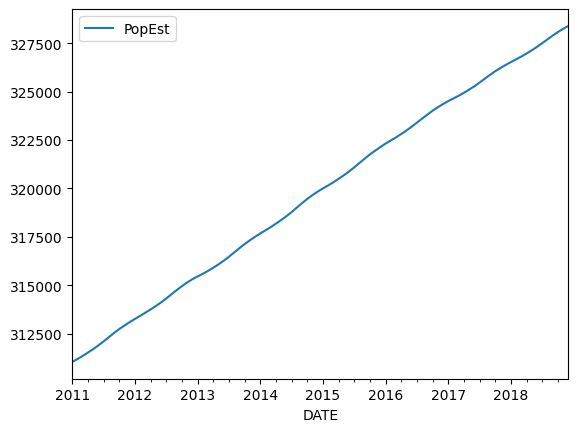

In [6]:
df.plot()

In [3]:
train = df.iloc[:84]
test = df.iloc[84:]

## using order 1

In [4]:
AR1fit = AR(train['PopEst'], lags=1).fit()
print(AR1fit.summary())
AR1fit.params

                            AutoReg Model Results                             
Dep. Variable:                 PopEst   No. Observations:                   84
Model:                     AutoReg(1)   Log Likelihood                -380.819
Method:               Conditional MLE   S.D. of innovations             23.789
Date:                Tue, 16 Apr 2024   AIC                            767.638
Time:                        11:03:59   BIC                            774.894
Sample:                    02-01-2011   HQIC                           770.553
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.9138    185.428      1.537      0.124     -78.518     648.346
PopEst.L1      0.9997      0.001   1718.076      0.000       0.999       1.001
                                    Roots           

const        284.913797
PopEst.L1      0.999686
dtype: float64

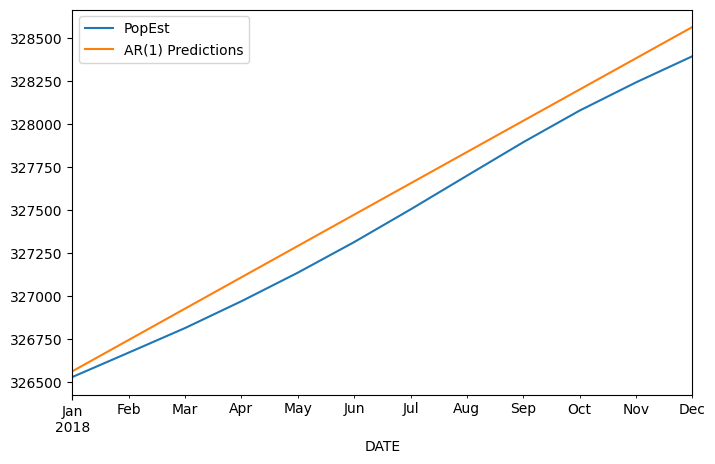

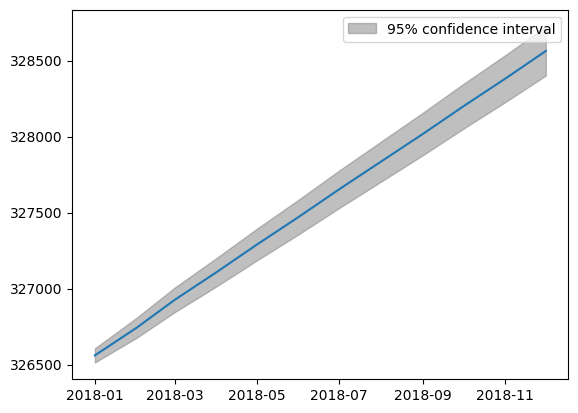

In [5]:
predictions1 = AR1fit.predict(start=84, end=95)
predictions1.rename('AR(1) Predictions', inplace=True)

test.plot(figsize=(8,5), legend=True)
predictions1.plot(legend=True)
AR1fit.plot_predict(start=84, end=95);

## using order 2

In [6]:
AR2fit = AR(train['PopEst'], lags=2).fit()
print(AR2fit.summary())
AR2fit.params

                            AutoReg Model Results                             
Dep. Variable:                 PopEst   No. Observations:                   84
Model:                     AutoReg(2)   Log Likelihood                -320.605
Method:               Conditional MLE   S.D. of innovations             12.072
Date:                Tue, 16 Apr 2024   AIC                            649.209
Time:                        11:05:14   BIC                            658.836
Sample:                    03-01-2011   HQIC                           653.075
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        137.3683     96.729      1.420      0.156     -52.218     326.954
PopEst.L1      1.8535      0.056     33.016      0.000       1.743       1.964
PopEst.L2     -0.8538      0.056    -15.212      0.0

const        137.368305
PopEst.L1      1.853490
PopEst.L2     -0.853836
dtype: float64

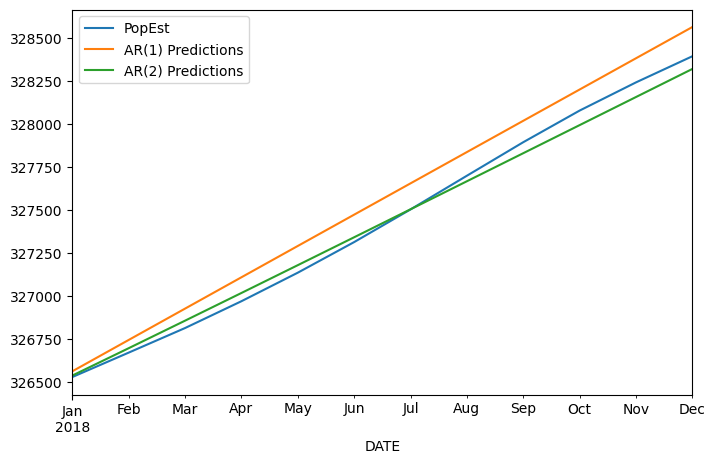

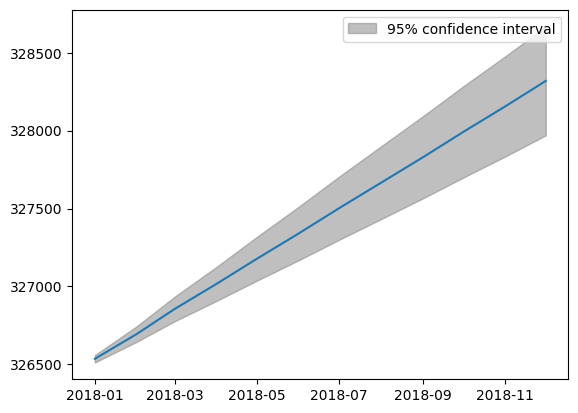

In [7]:
predictions2 = AR2fit.predict(start=84, end=95)
predictions2.rename('AR(2) Predictions', inplace=True)

test.plot(figsize=(8,5), legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)

AR2fit.plot_predict(start=84, end=95);

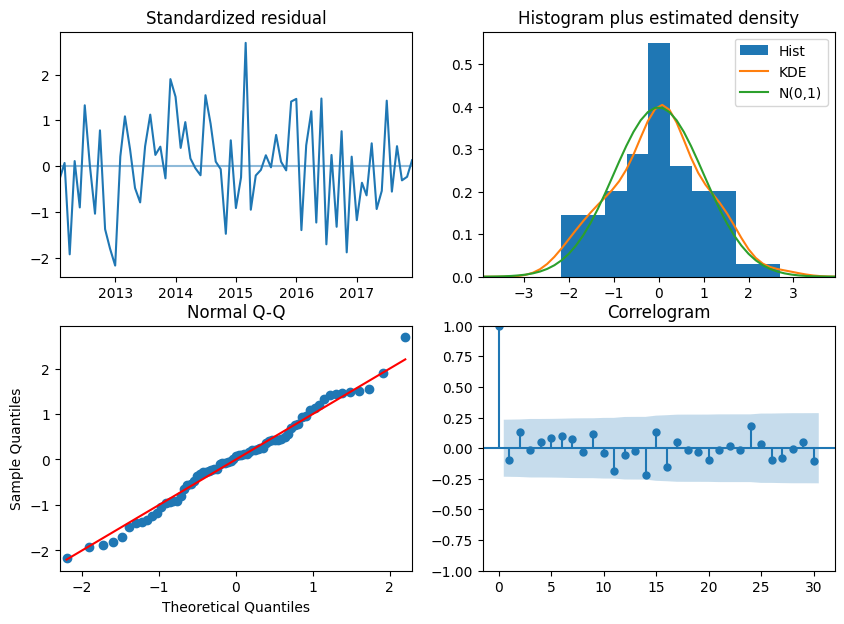

In [39]:
fig = plt.figure(figsize=(10, 7))
fig = AR2fit.plot_diagnostics(fig=fig, lags=30)

## let statsmodels decide the order

In [9]:
# ARfit = model.fit(ic='t-stat') # this t-stat provides lag=8 which is still the best when looked at mse
# ARfit.params

# maxlag- max lag to try,
# glob- whether to use a global search across all combinations of lags i.e. 2**maxlag models
select_order = ar_select_order(train['PopEst'], maxlag=15, glob=True)
print(select_order.ar_lags)

ARfit = select_order.model.fit()
print(ARfit.summary())

[1, 2, 3, 12, 13, 14]
                            AutoReg Model Results                             
Dep. Variable:                 PopEst   No. Observations:                   84
Model:             Restr. AutoReg(14)   Log Likelihood                -201.890
Method:               Conditional MLE   S.D. of innovations              4.328
Date:                Tue, 16 Apr 2024   AIC                            419.780
Time:                        11:06:55   BIC                            437.768
Sample:                    03-01-2012   HQIC                           426.925
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.6183     50.411      1.361      0.173     -30.185     167.421
PopEst.L1      2.1837      0.086     25.372      0.000       2.015       2.352
PopEst.L2     -1.5128      0.1

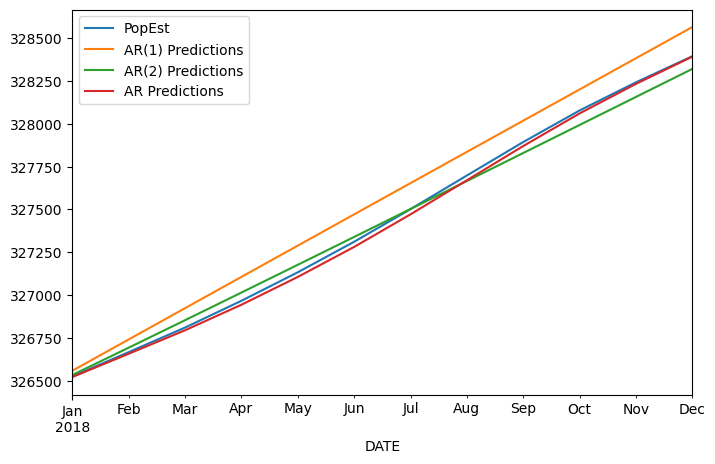

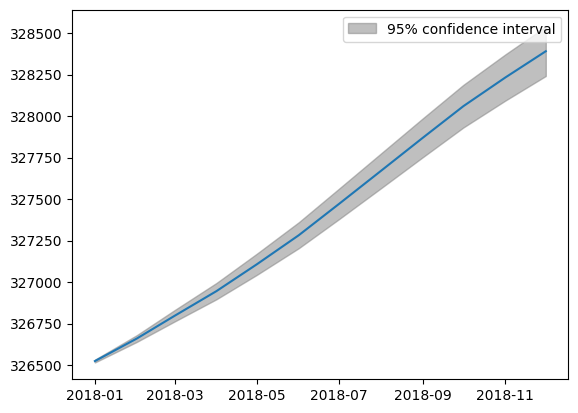

In [10]:
predictions = ARfit.predict(84,95)
predictions.rename('AR Predictions', inplace=True)

test.plot(figsize=(8,5), legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions.plot(legend=True)

ARfit.plot_predict(start=84, end=95);

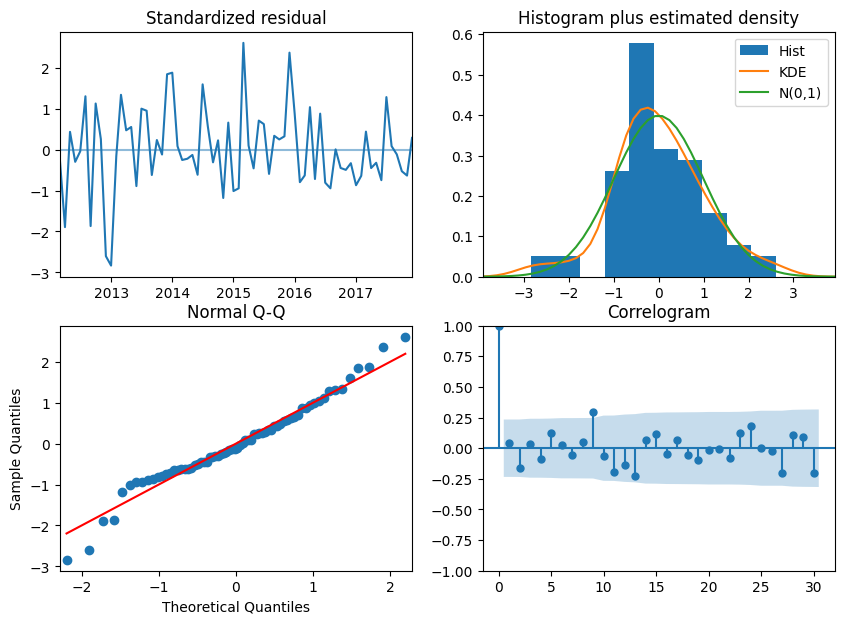

In [11]:
fig = plt.figure(figsize=(10, 7))
fig = ARfit.plot_diagnostics(fig=fig, lags=30)

In [12]:
from sklearn.metrics import mean_squared_error
labels = ['AR1', 'AR2', 'AR']
preds = [predictions1, predictions2, predictions]
for i in range(3):
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} MSE was : {error}')

AR1 MSE was : 17449.71423587912
AR2 MSE was : 2713.258501569486
AR MSE was : 429.2089480366505


## forecasting into future

In [14]:
model = AR(df['PopEst'], lags=[1, 2, 3, 12, 13, 14])
ARfit = model.fit()
print(ARfit.params)
print(ARfit.summary())
forcasted_values = ARfit.predict(start=len(df), end=len(df)+12).rename('Forecast')
forcasted_values

const         74.010473
PopEst.L1      2.175355
PopEst.L2     -1.505278
PopEst.L3      0.328484
PopEst.L12     0.642457
PopEst.L13    -1.226483
PopEst.L14     0.585298
dtype: float64
                            AutoReg Model Results                             
Dep. Variable:                 PopEst   No. Observations:                   96
Model:             Restr. AutoReg(14)   Log Likelihood                -231.538
Method:               Conditional MLE   S.D. of innovations              4.074
Date:                Tue, 16 Apr 2024   AIC                            479.076
Time:                        11:08:52   BIC                            498.330
Sample:                    03-01-2012   HQIC                           486.806
                         - 12-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.0105     4

2019-01-01    328538.426867
2019-02-01    328679.640189
2019-03-01    328822.770903
2019-04-01    328977.284380
2019-05-01    329143.354695
2019-06-01    329321.114352
2019-07-01    329509.489926
2019-08-01    329703.319920
2019-09-01    329895.897276
2019-10-01    330078.697686
2019-11-01    330243.963918
2019-12-01    330395.774559
2020-01-01    330540.285659
Freq: MS, Name: Forecast, dtype: float64

<AxesSubplot:xlabel='DATE'>

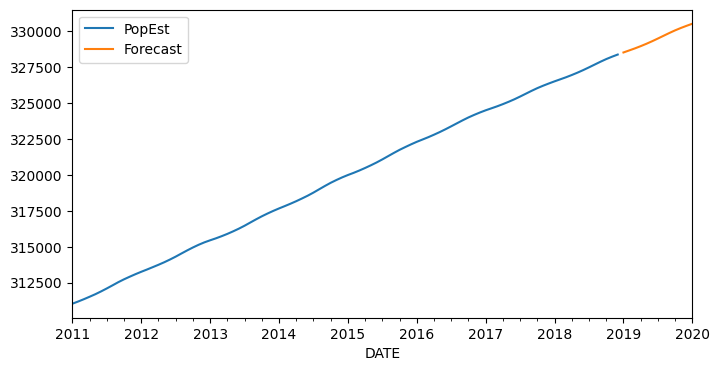

In [15]:
df.plot(figsize=(8,4), legend=True)
forcasted_values.plot(legend=True)

# ARMA(p,q) and ARIMA(p,d,q)
# Autoregressive Moving Averages

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets. In short MA is nothing but contribution of residuals from t-1 or so terms (assumption: $residual = y_{t}-MA_{t-1}$)

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well- I(d) component where d is identified based on the number of differences such that timeseries becomes stationary


# ARIMA Model
* <b>p:</b> The number of lag observations included in the model, also called the lag order.
* <b>d:</b> The number of times that the raw observations are differenced, also called the degree of differencing to make it stationary.
* <b>q:</b> The number of residual error from previous lags to include.


In [2]:
df1 = pd.read_csv('data/DailyTotalFemaleBirths.csv', parse_dates=True, index_col='Date')
df1.index.freq = 'D'
# to extract stationary data we use only initial 120 values i.e. first four months
df1 = df1[:120]

df2 = pd.read_csv('data/TradeInventories.csv', parse_dates=True, index_col='Date')
df2.index.freq = 'MS'

In [3]:
from datetime import datetime
def parser(x):
	return datetime.strptime('190'+x[3:], '%Y-%m')
df3 = pd.read_csv('data/sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
df3.index.freq = 'MS'
df3.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


## dataset 1

<AxesSubplot:xlabel='Date'>

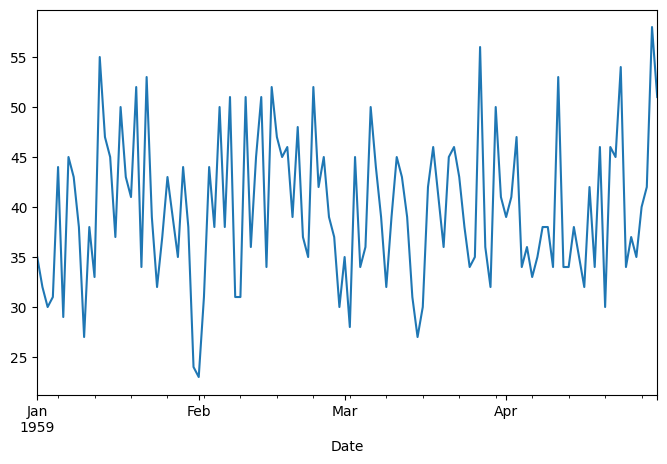

In [144]:
# check data
df1['Births'].plot(figsize=(8,5))

In [146]:
# check for stationarity
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


test statistic is lower than 1%, 5% and 10% critical values, hence 99% confidence that it is stationary

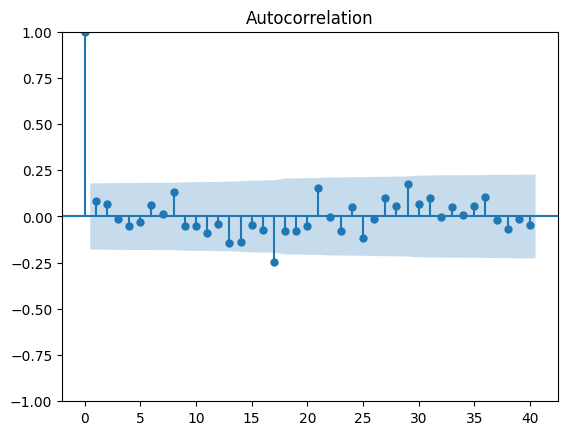

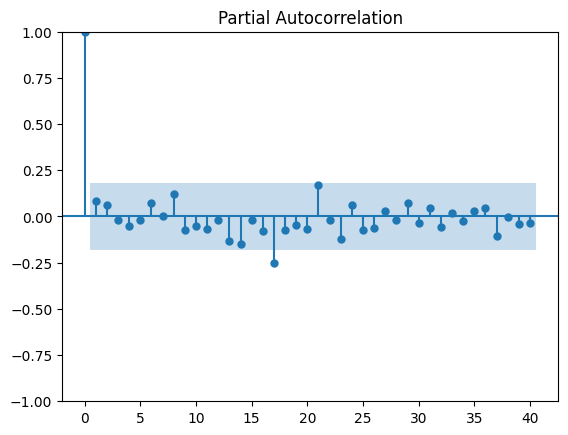

In [ ]:
# manually finding values for p,d,q
plot_acf(df1['Births'], lags=40);
plot_pacf(df1['Births'], lags=40);

determine model parameters<br>
#########################################################<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;ACF&ensp;&ensp;&ensp;&ensp; &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;PACF<br>
AR&ensp;&ensp;&ensp;&ensp;&ensp;geometric(gradual decrease)&ensp;&ensp;&ensp;&ensp;significant till p lags<br>
MA&ensp;&ensp;&ensp;&ensp;&nbsp;significant till p lags&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;geometric<br>
ARMA&ensp;&ensp;geometric&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;geometric<br>
###########################################################<br>
nlags: number of samples for autocorrelation to be returned for autucorrelation 

In [82]:
# train model
train = df1.iloc[:90]
test = df1.iloc[90:]

model = ARIMA(train['Births'], order=(0, 0, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                          ARIMA   Log Likelihood                -308.379
Date:                Wed, 17 Apr 2024   AIC                            620.759
Time:                        06:23:12   BIC                            625.759
Sample:                    01-01-1959   HQIC                           622.775
                         - 03-31-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7667      0.786     50.609      0.000      38.227      41.307
sigma2        55.4236     10.155      5.458      0.000      35.520      75.327
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.41   Prob(JB):                         0.42
Heteroskedasticity (H):               0.90   Skew:                             0.06
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

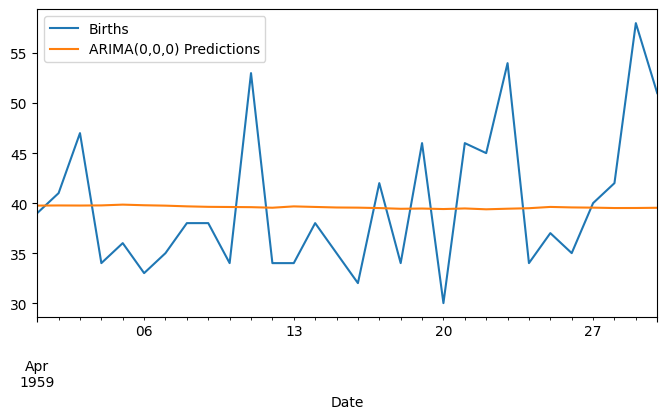

In [85]:
# predictions
prediction = list()
for i in range(len(test)):
    # train on initial values and append the next test value as soon as it is forecasted
    train = df1['Births'].iloc[:90+i]
    model = ARIMA(train, order=(0,0,0))
    model_fit = model.fit()
    # forecast next value in series
    # forecast method works as it will always predict the next value in 
    # index of time based on training data
    output = model_fit.forecast()
    yhat = output[0]
    prediction.append(yhat)
    
# plot actual vs predicted values
prediction = pd.Series(prediction, index=test.index).rename('ARIMA(0,0,0) Predictions')
test.plot(legend=True,figsize=(8,4))
prediction.plot(legend=True)

## dataset 2

<AxesSubplot:xlabel='Date'>

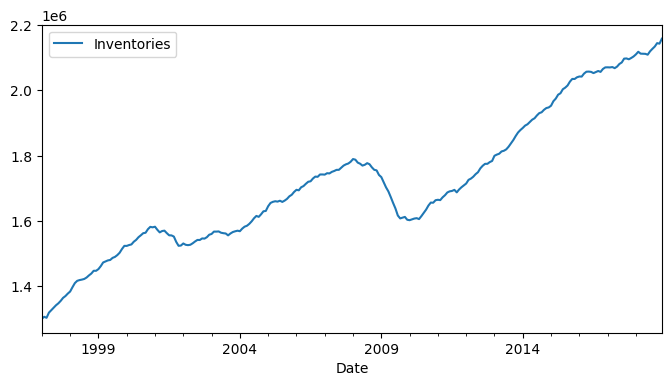

In [165]:
# check data
df2.plot(figsize=(8,4))

In [166]:
# check stationarity
adf_test(df2['Inventories'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.087684
p-value                   0.950652
# lags used               5.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [ ]:
df2['d1'] = diff(df2['Inventories'], k_diff=1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


This confirms that we reached stationarity after the first difference hence d=1.

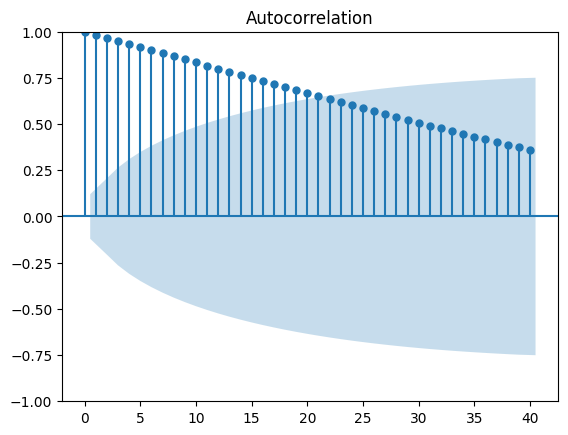

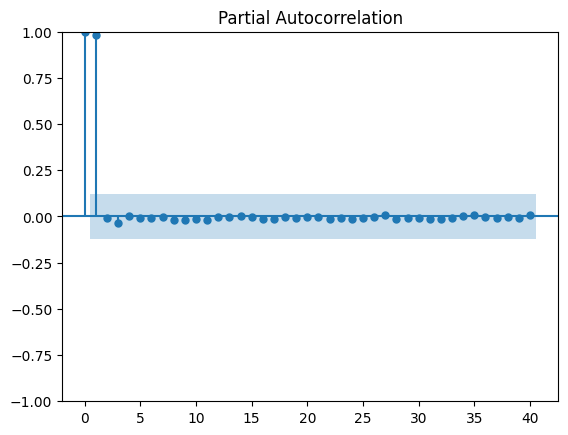

In [8]:
plot_acf(df2['Inventories'], lags=40);
plot_pacf(df2['Inventories'], lags=40);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

In [86]:
train = df2.iloc[:252]
test = df2.iloc[252:]

# ar=1, d=1
model = ARIMA(train['Inventories'], order=(1, 1, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  252
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2604.050
Date:                Wed, 17 Apr 2024   AIC                           5212.101
Time:                        06:24:43   BIC                           5219.152
Sample:                    01-01-1997   HQIC                          5214.938
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0099      0.003      3.010      0.003       0.003       0.016
sigma2      2.711e+07   6.43e-13   4.21e+19      0.000    2.71e+07    2.71e+07
===================================================================================
Ljung-Box (L1) (Q):                  85.76   Jarque-Bera (JB):                96.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -1.16
Prob(H) (two-sided):                  0.63   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

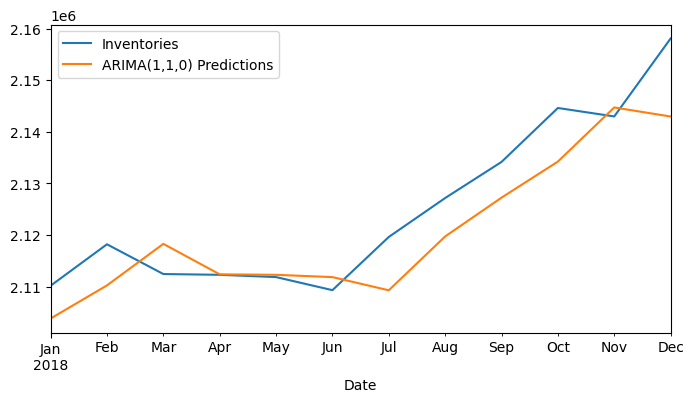

In [97]:
# predictions
prediction = list()
for i in range(len(test)):
    # train on initial values and append the next test value as soon as it is forecasted
    train = df2['Inventories'].iloc[:252+i]
    model = ARIMA(train, order=(1,1,0))
    model_fit = model.fit()
    # forecast next value in series
    # forecast method works as it will always predict the next value in 
    # index of time based on training data
    output = model_fit.forecast()
    yhat = output[0]
    prediction.append(yhat)
    
# plot actual vs predicted values
prediction = pd.Series(prediction, index=test.index).rename('ARIMA(1,1,0) Predictions')
test.plot(legend=True,figsize=(8,4))
prediction.plot(legend=True)

## dataset 3

<AxesSubplot:xlabel='Month'>

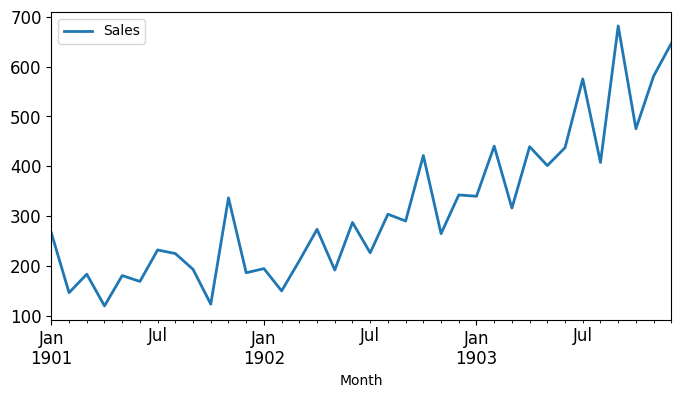

In [47]:
df3.plot(figsize=(8,4), linewidth=2, fontsize=12)

In [48]:
# check stationarity
adf_test(df3)

Augmented Dickey-Fuller Test: 
ADF test statistic       3.060142
p-value                  1.000000
# lags used             10.000000
# observations          25.000000
critical value (1%)     -3.723863
critical value (5%)     -2.986489
critical value (10%)    -2.632800
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [7]:
df3['d1'] = diff(df3['Sales'], k_diff=1)

adf_test(df3['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic     -7.249074e+00
p-value                 1.799857e-10
# lags used             1.000000e+00
# observations          3.300000e+01
critical value (1%)    -3.646135e+00
critical value (5%)    -2.954127e+00
critical value (10%)   -2.615968e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


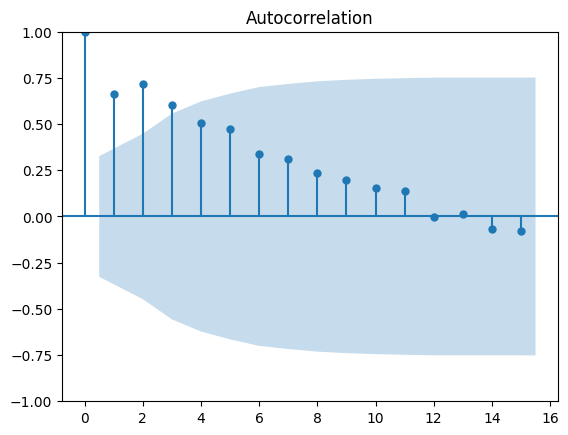

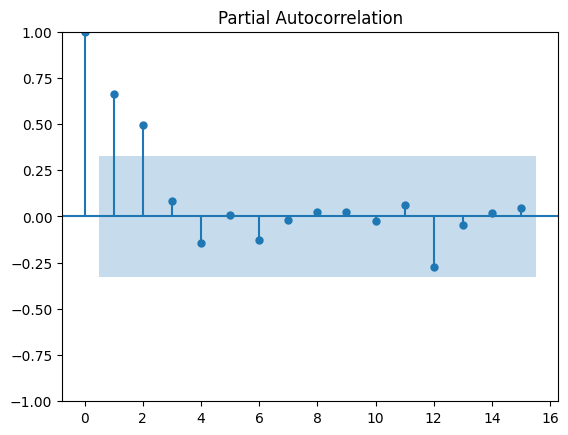

In [8]:
plot_acf(df3['Sales'], lags=15);
plot_pacf(df3['Sales'], lags=15);

Autocorrelation is present, ar/p = 2 should help to handle it

In [9]:
train = df3['Sales'].iloc[:-15]
test = df3['Sales'].iloc[-15:]

model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   21
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -111.513
Date:                Wed, 17 Apr 2024   AIC                            229.025
Time:                        07:04:31   BIC                            232.013
Sample:                    01-01-1901   HQIC                           229.609
                         - 09-01-1902                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7608      0.293     -2.599      0.009      -1.334      -0.187
ar.L2         -0.1890      0.238     -0.795      0.427      -0.655       0.277
sigma2      3966.1618   1589.789      2.495      0.0

78.81641710431452

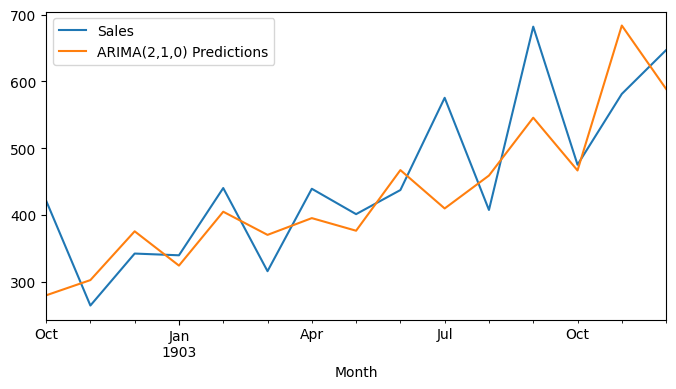

In [13]:
# predictions
prediction = list()
for i in range(len(test)):
    # train on initial values and append the next test value as soon as it is forecasted
    train = df3['Sales'].iloc[:-15+i]
    model = ARIMA(train, order=(2,1,0), trend='t', trend_offset=0)
    model_fit = model.fit()
    # forecast next value in series
    # forecast method works as it will always predict the next value in 
    # index of time based on training data
    output = model_fit.forecast()
    #print(output)
    yhat = output[0]
    prediction.append(yhat)
    
# plot actual vs predicted values
prediction = pd.Series(prediction, index=test.index).rename('ARIMA(2,1,0) Predictions')
test.plot(legend=True,figsize=(8,4))
prediction.plot(legend=True)
np.sqrt(mean_squared_error(prediction, test))

## Optimizing p,d,q values using RMSE

In [14]:
import warnings
warnings.filterwarnings('ignore')
# DEFINE p,d,q values using appropriate ranges
def evaluate_arima_model(data, forecast_num, arima_order): 
    # forecast_num: difenes the number of samples to be done forecasting for
    train = data[:-forecast_num]
    test = data[-forecast_num:]
    
    # forecast values in for test data and append the forecast test data to
    # train data so that next value is forcasted
    predictions = list()    
    for t in range(len(test)):
        train = data[:-forecast_num+t]
        model = ARIMA(train, order=arima_order)#, trend='t', trend_offset=0)        
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]        
        predictions.append(yhat)
        
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    return rmse

# initially set best configuration as None
best_cfg = None

# function to evaluate combinations of p, d, and q values for an ARIMA model
def evaluate_model(dataset, p_values, d_values, q_values, forecast_num):
    best_score = float("inf") 
    global best_cfg  
    for p in p_values:        
        for d in d_values:            
            for q in q_values:                
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(data=dataset, forecast_num=forecast_num, arima_order=order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s, RMSE=%.3f' %(order,mse))
                except:
                    continue
    # print best configuration or values of p, d & q
    print('Best ARIMA%s RMSE=%.3f' %(best_cfg, best_score))            

# set range for p, d & q values to be tested for best configuration
p_values = range(0,5)
d_values = range(0,2)
q_values = range(0,5)

# print best values for p,d,q
evaluate_model(df3['Sales'], p_values, d_values, q_values, forecast_num=15)
# best values = (3, 1, 3); RMSE = 72.817

ARIMA(0, 0, 0), RMSE=220.088


ARIMA(0, 0, 1), RMSE=189.903
ARIMA(0, 0, 2), RMSE=152.321
ARIMA(0, 0, 3), RMSE=155.092
ARIMA(0, 0, 4), RMSE=141.940
ARIMA(0, 1, 0), RMSE=134.789
ARIMA(0, 1, 1), RMSE=107.264
ARIMA(0, 1, 2), RMSE=77.250
ARIMA(0, 1, 3), RMSE=78.159
ARIMA(0, 1, 4), RMSE=87.530
ARIMA(1, 0, 0), RMSE=151.369
ARIMA(1, 0, 1), RMSE=115.548
ARIMA(1, 0, 2), RMSE=86.220
ARIMA(1, 0, 3), RMSE=107.806
ARIMA(1, 0, 4), RMSE=97.368
ARIMA(1, 1, 0), RMSE=90.357
ARIMA(1, 1, 1), RMSE=92.759
ARIMA(1, 1, 2), RMSE=94.286
ARIMA(1, 1, 3), RMSE=85.166
ARIMA(1, 1, 4), RMSE=88.357
ARIMA(2, 0, 0), RMSE=105.200
ARIMA(2, 0, 1), RMSE=103.424
ARIMA(2, 0, 2), RMSE=102.611
ARIMA(2, 0, 3), RMSE=91.525
ARIMA(2, 0, 4), RMSE=94.992
ARIMA(2, 1, 0), RMSE=88.324
ARIMA(2, 1, 1), RMSE=92.939
ARIMA(2, 1, 2), RMSE=88.095
ARIMA(2, 1, 3), RMSE=80.819
ARIMA(2, 1, 4), RMSE=79.820
ARIMA(3, 0, 0), RMSE=102.583
ARIMA(3, 0, 1), RMSE=104.381
ARIMA(3, 0, 2), RMSE=103.323
ARIMA(3, 0, 3), RMSE=97.794
ARIMA(3, 0, 4), RMSE=95.013
ARIMA(3, 1, 0), RMSE=94.696
ARIMA

72.81725628746874

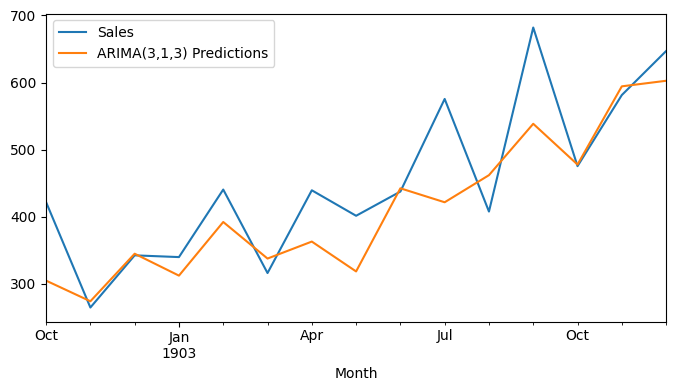

In [21]:
train = df3['Sales'].iloc[:-15]
test = df3['Sales'].iloc[-15:]

# predictions
prediction = list()
for i in range(len(test)):
    # train on initial values and append the next test value as soon as it is forecasted
    train = df3['Sales'].iloc[:-15+i]
    model = ARIMA(train, order=(3,1,3))
    model_fit = model.fit()
    # forecast next value in series
    # forecast method works as it will always predict the next value in 
    # index of time based on training data
    output = model_fit.forecast()
    #print(output)
    yhat = output[0]
    prediction.append(yhat)
    
# plot actual vs predicted values
prediction = pd.Series(prediction, index=test.index).rename('ARIMA(3,1,3) Predictions')
test.plot(legend=True,figsize=(8,4))
prediction.plot(legend=True)
np.sqrt(mean_squared_error(prediction, test))

## dataset 4

In [23]:
df4 = pd.read_csv('data/airline_passengers.csv', parse_dates=True, index_col='Month')
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


<AxesSubplot:xlabel='Month'>

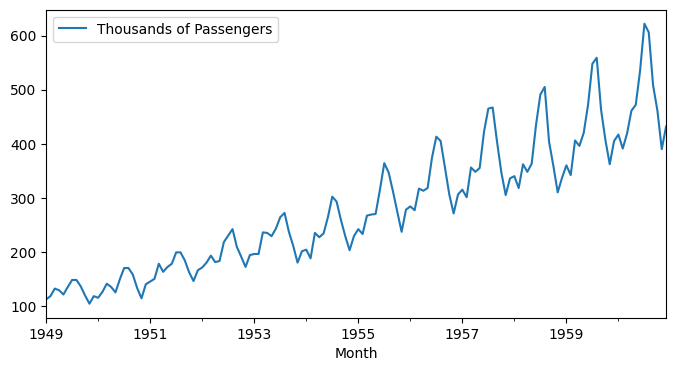

In [24]:
# check data
df4.plot(figsize=(8,4))

In [29]:
# check stationarity
adf_test(df4['Thousands of Passengers'])

df4['d1'] = diff(df4['Thousands of Passengers'], k_diff=1)
adf_test(df4['d1'])

df4['d2'] = diff(df4['Thousands of Passengers'], k_diff=2)
adf_test(df4['d2'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: 
ADF test statistic       -2.829267
p-value                   0.054213
# lags used              12.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: 
ADF test statistic     -1.638423e+01
p-value                 2.732892e-29
# lags used             1.100000e+01
# observations          1.300000e+02
critical value (1%)    -3.481

d = 2, as it becomes stationary after two differences

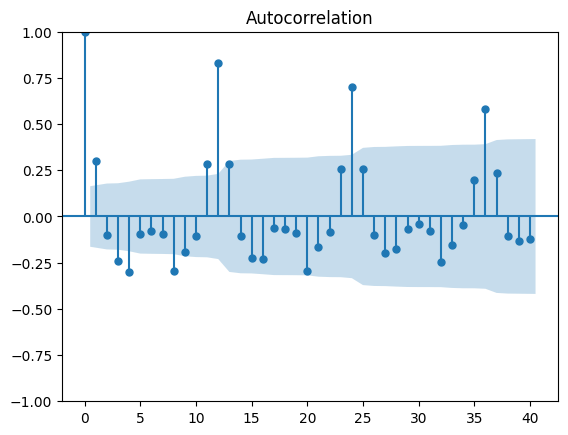

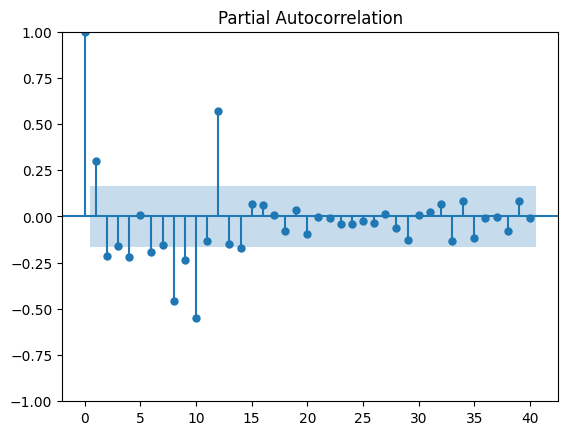

In [67]:
plot_acf(df4['Thousands of Passengers'].diff(1)[1:], lags=40);
plot_pacf(df4['Thousands of Passengers'].diff(1)[1:], lags=40);

MA/p = 1

In [41]:
train = df4['Thousands of Passengers'].iloc[:-15]
test = df4['Thousands of Passengers'].iloc[-15:]

model = ARIMA(train, order=(1,2,0))
model_fit = model.fit()
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Thousands of Passengers   No. Observations:                  129
Model:                      ARIMA(1, 2, 0)   Log Likelihood                -635.182
Date:                     Wed, 17 Apr 2024   AIC                           1274.363
Time:                             07:36:59   BIC                           1280.052
Sample:                         01-01-1949   HQIC                          1276.674
                              - 09-01-1959                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2116      0.097     -2.175      0.030      -0.402      -0.021
sigma2      1292.8652    146.643      8.816      0.000    1005.450    1580.280
Ljung-Box (L

40.80369091112075

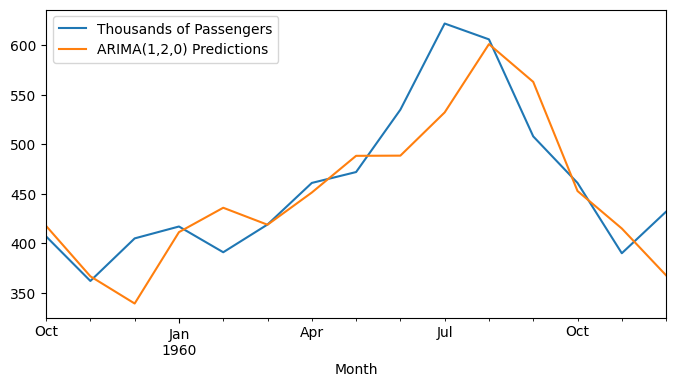

In [47]:
# predictions
prediction = list()
for i in range(len(test)):
    # train on initial values and append the next test value as soon as it is forecasted
    train = df4['Thousands of Passengers'].iloc[:-15+i]
    model = ARIMA(train, order=(1,2,0))
    model_fit = model.fit()
    # forecast next value in series
    # forecast method works as it will always predict the next value in 
    # index of time based on training data
    output = model_fit.forecast()
    #print(output)
    yhat = output[0]
    prediction.append(yhat)
    
# plot actual vs predicted values
prediction = pd.Series(prediction, index=test.index).rename('ARIMA(1,2,0) Predictions')
test.plot(legend=True,figsize=(8,4))
prediction.plot(legend=True)
np.sqrt(mean_squared_error(prediction, test))

In [44]:
import warnings
warnings.filterwarnings('ignore')
# DEFINE p,d,q values using appropriate ranges
def evaluate_arima_model(data, forecast_num, arima_order): 
    # forecast_num: difenes the number of samples to be done forecasting for
    train = data[:-forecast_num]
    test = data[-forecast_num:]
    
    # forecast values in for test data and append the forecast test data to
    # train data so that next value is forcasted
    predictions = list()    
    for t in range(len(test)):
        train = data[:-forecast_num+t]
        model = ARIMA(train, order=arima_order)#, trend='t', trend_offset=0)        
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]        
        predictions.append(yhat)
        
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    return rmse

# initially set best configuration as None
best_cfg = None

# function to evaluate combinations of p, d, and q values for an ARIMA model
def evaluate_model(dataset, p_values, d_values, q_values, forecast_num):
    best_score = float("inf") 
    global best_cfg  
    for p in p_values:        
        for d in d_values:            
            for q in q_values:                
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(data=dataset, forecast_num=forecast_num, arima_order=order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s, RMSE=%.3f' %(order,mse))
                except:
                    continue
    # print best configuration or values of p, d & q
    print('Best ARIMA%s RMSE=%.3f' %(best_cfg, best_score))            

# set range for p, d & q values to be tested for best configuration
p_values = range(0,5)
d_values = range(0,3)
q_values = range(0,5)

# print best values for p,d,q
evaluate_model(df4['Thousands of Passengers'], p_values, d_values, q_values, forecast_num=15)
# best values = (2, 1, 2); RMSE = 40

ARIMA(0, 0, 0), RMSE=204.202
ARIMA(0, 0, 1), RMSE=117.139
ARIMA(0, 0, 2), RMSE=73.775
ARIMA(0, 0, 3), RMSE=65.225
ARIMA(0, 0, 4), RMSE=58.293
ARIMA(0, 1, 0), RMSE=52.225
ARIMA(0, 1, 1), RMSE=47.412
ARIMA(0, 1, 2), RMSE=50.106
ARIMA(0, 1, 3), RMSE=49.890
ARIMA(0, 1, 4), RMSE=45.370
ARIMA(0, 2, 0), RMSE=59.162
ARIMA(0, 2, 1), RMSE=52.573
ARIMA(0, 2, 2), RMSE=47.563
ARIMA(0, 2, 3), RMSE=50.511
ARIMA(0, 2, 4), RMSE=52.880
ARIMA(1, 0, 0), RMSE=52.167
ARIMA(1, 0, 1), RMSE=47.682
ARIMA(1, 0, 2), RMSE=49.633
ARIMA(1, 0, 3), RMSE=50.714
ARIMA(1, 0, 4), RMSE=46.493
ARIMA(1, 1, 0), RMSE=48.233
ARIMA(1, 1, 1), RMSE=50.064
ARIMA(1, 1, 2), RMSE=45.231
ARIMA(1, 1, 3), RMSE=45.563
ARIMA(1, 1, 4), RMSE=46.139
ARIMA(1, 2, 0), RMSE=58.818
ARIMA(1, 2, 1), RMSE=48.390
ARIMA(1, 2, 2), RMSE=50.274
ARIMA(1, 2, 3), RMSE=49.932
ARIMA(1, 2, 4), RMSE=50.546
ARIMA(2, 0, 0), RMSE=48.238
ARIMA(2, 0, 1), RMSE=50.071
ARIMA(2, 0, 2), RMSE=49.813
ARIMA(2, 0, 3), RMSE=45.742
ARIMA(2, 0, 4), RMSE=48.536
ARIMA(2, 1, 0), RM

## dataset 5

In [2]:
data = pd.read_excel("data/Superstore.xls")
data[data.Category=='Office Supplies'][['Order Date', 'Sales']]
data.set_index('Order Date', inplace=True)
df5 = pd.DataFrame()
df5['Sales'] = data['Sales'].resample('MS').mean()
df5.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


<AxesSubplot:xlabel='Order Date'>

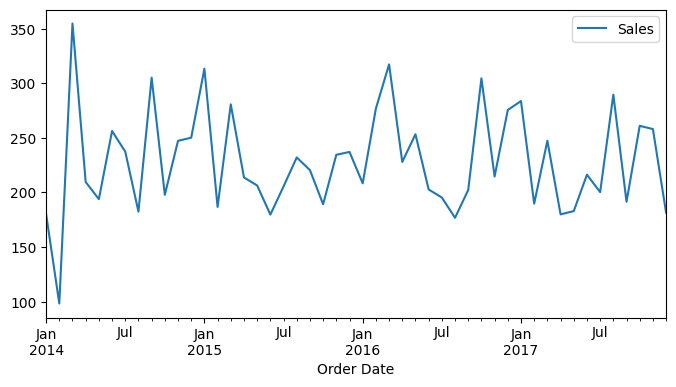

In [70]:
# plot data
df5.plot(figsize=(8, 4))

In [74]:
# check stationarity
adf_test(df5['Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.286567
p-value                  0.015490
# lags used             10.000000
# observations          37.000000
critical value (1%)     -3.620918
critical value (5%)     -2.943539
critical value (10%)    -2.610400
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


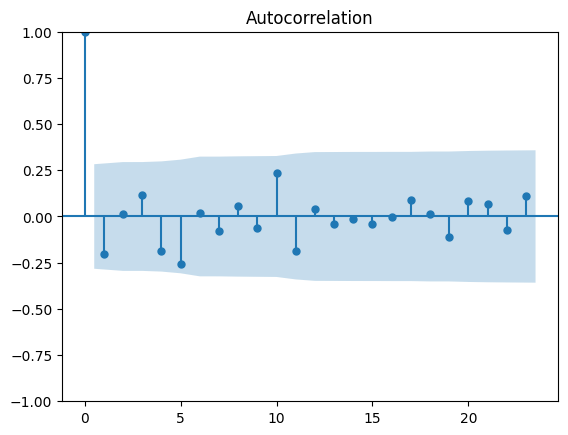

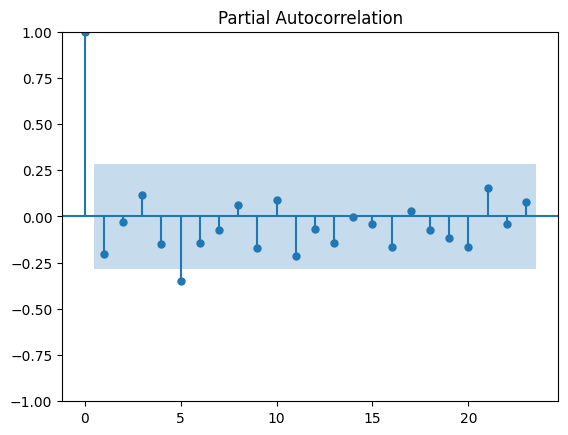

In [75]:
plot_acf(df5['Sales'], lags=23);
plot_pacf(df5['Sales'], lags=23);

In [78]:
import warnings
warnings.filterwarnings('ignore')
# DEFINE p,d,q values using appropriate ranges
def evaluate_arima_model(data, forecast_num, arima_order): 
    # forecast_num: difenes the number of samples to be done forecasting for
    train = data[:-forecast_num]
    test = data[-forecast_num:]
    
    # forecast values in for test data and append the forecast test data to
    # train data so that next value is forcasted
    predictions = list()    
    for t in range(len(test)):
        train = data[:-forecast_num+t]
        model = ARIMA(train, order=arima_order)#, trend='t', trend_offset=0)        
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]        
        predictions.append(yhat)
        
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    return rmse

# initially set best configuration as None
best_cfg = None

# function to evaluate combinations of p, d, and q values for an ARIMA model
def evaluate_model(dataset, p_values, d_values, q_values, forecast_num):
    best_score = float("inf") 
    global best_cfg  
    for p in p_values:        
        for d in d_values:            
            for q in q_values:                
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(data=dataset, forecast_num=forecast_num, arima_order=order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s, RMSE=%.3f' %(order,mse))
                except:
                    continue
    # print best configuration or values of p, d & q
    print('Best ARIMA%s RMSE=%.3f' %(best_cfg, best_score))            

# set range for p, d & q values to be tested for best configuration
p_values = range(0,5)
d_values = range(0,3)
q_values = range(0,5)

# print best values for p,d,q
evaluate_model(df5['Sales'], p_values, d_values, q_values, forecast_num=18)
# best values = (2, 1, 2); RMSE = 40

ARIMA(0, 0, 0), RMSE=42.889


ARIMA(0, 0, 1), RMSE=43.792
ARIMA(0, 0, 2), RMSE=45.241
ARIMA(0, 0, 3), RMSE=44.665
ARIMA(0, 0, 4), RMSE=31.076
ARIMA(0, 1, 0), RMSE=62.253
ARIMA(0, 1, 1), RMSE=42.890
ARIMA(0, 1, 2), RMSE=43.491
ARIMA(0, 1, 3), RMSE=43.716
ARIMA(0, 1, 4), RMSE=37.058
ARIMA(0, 2, 0), RMSE=109.203
ARIMA(0, 2, 1), RMSE=63.086
ARIMA(0, 2, 2), RMSE=45.049
ARIMA(0, 2, 3), RMSE=53.528
ARIMA(0, 2, 4), RMSE=42.728
ARIMA(1, 0, 0), RMSE=43.303
ARIMA(1, 0, 1), RMSE=39.909
ARIMA(1, 0, 2), RMSE=41.561
ARIMA(1, 0, 3), RMSE=42.149
ARIMA(1, 0, 4), RMSE=32.273
ARIMA(1, 1, 0), RMSE=51.080
ARIMA(1, 1, 1), RMSE=43.193
ARIMA(1, 1, 2), RMSE=46.314
ARIMA(1, 1, 3), RMSE=47.996
ARIMA(1, 1, 4), RMSE=42.859
ARIMA(1, 2, 0), RMSE=77.627
ARIMA(1, 2, 1), RMSE=51.926
ARIMA(1, 2, 2), RMSE=48.715
ARIMA(1, 2, 3), RMSE=49.316
ARIMA(2, 0, 0), RMSE=44.697
ARIMA(2, 0, 1), RMSE=42.429


31.07550942552526

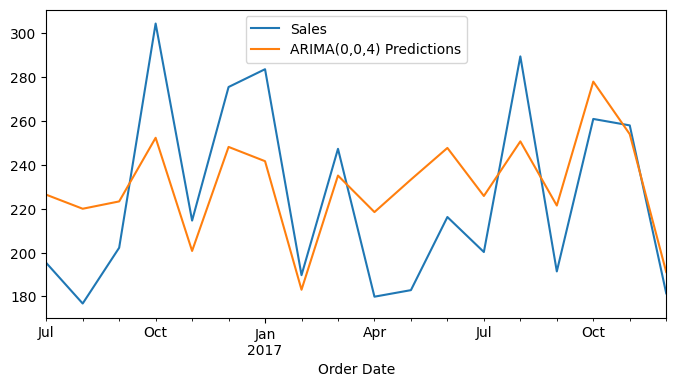

In [12]:
train = df5['Sales'].iloc[:-18]
test = df5['Sales'].iloc[-18:]

# predictions
prediction = list()
for i in range(len(test)):
    # train on initial values and append the next test value as soon as it is forecasted
    train = df5['Sales'].iloc[:-18+i]
    model = ARIMA(train, order=(0,0,4))
    model_fit = model.fit()
    # forecast next value in series
    # forecast method works as it will always predict the next value in 
    # index of time based on training data
    output = model_fit.forecast()
    #print(output)
    yhat = output[0]
    prediction.append(yhat)

# plot actual vs predicted values
prediction = pd.Series(prediction, index=test.index).rename('ARIMA(0,0,4) Predictions')
test.plot(legend=True,figsize=(8,4))
prediction.plot(legend=True)
np.sqrt(mean_squared_error(prediction, test))